# Mixed-effects Models in `R`
As the final part of this lesson, we turn to the process of fitting LME models using `R`, as well as options around inference. These examples will all be fairly basic, but we will see more variety in the workshop this week. In addition, we will see that there are *two* main options in `R` for fitting LME models. The first is the `lme()` function from the `nlme` package and the second is the `lmer()` function from the `lme4` package. We will discuss both below, as well as their advantages and disadvantages.

## Fitting Mixed-effects Models with `nlme`
We will start with the `nlme` package, both because it is the *older* of the two and because it is already familiar from the `gls()` function. To fit a LME model, we use the `lme()` function, which has a syntax very similar to the `gls()` function, but with the addition of a `random=` option for specifying the random effects. To understand how to use this, we will return to the long-formatted `anxiety` data from `datarium`.

In [1]:
library('datarium')
library('reshape2')

data('anxiety')
anxiety.grp3 <- anxiety[anxiety$group == 'grp3',]   # high exercise group
anxiety.grp3 <- subset(anxiety.grp3, select=-group) # remove group column

# repeats and number of subjects
t <- 3
n <- dim(anxiety.grp3)[1]

# reshape wide -> long
anxiety.long <- melt(anxiety.grp3,             # wide data frame
                     id.vars='id',             # what stays fixed?
                     variable.name="time",     # name for the new predictor
                     value.name="score")       # name for the new outcome

anxiety.long           <- anxiety.long[order(anxiety.long$id),] # order by ID
rownames(anxiety.long) <- seq(1,n*t)                            # fix row names
anxiety.long$id        <- as.factor(anxiety.long$id)            # convert ID to factor


In [2]:
head(anxiety.long)

  id time score
1 31   t1  14.6
2 31   t2  13.0
3 31   t3  11.7
4 32   t1  15.0
5 32   t2  13.0
6 32   t3  11.9

Our multilevel model for these data was specified earlier as

$$
\begin{alignat*}{2}
    y_{ij}    &= \mu_{i} + \alpha_{j} + \eta_{ij} &\quad\text{Level 1} \\
    \mu_{i}   &= \mu + \xi_{i}                    &\quad\text{Level 2} \\
\end{alignat*}
$$

which we can collapse to a single level by replacing $\mu_{i}$ with $\mu + \xi_{i}$ at Level 1. This gives the LME model

$$
y_{ij} = \mu + \alpha_{j} + \xi_{i} + \eta_{ij},
$$

where we have *two* fixed-effects of $\mu$ and $\alpha_{j}$, and *two* random-effects of $\xi_{i}$ and $\eta_{ij}$. To fit this model using `lme()` we use

In [3]:
library(nlme)
lme.mod <- lme(score ~ time, random= ~ 1|id, data=anxiety.long)

### Specifying Random-effects
As we can see above, the newest element of the `lme()` function is the `random=` argument. This uses a syntax very similar to what we have seen before when using `correlation=` and `weights=` with `gls()`. However, we need to think about this a little differently because we are not defining how we want a particular covariance structure to apply to the data. Instead, we are giving the *structure* of the random effects. 

We can think of this as simply a direct implementation of the LME equation above. We have

$$
y_{ij} = \overbrace{\mu + \alpha_{j}}^{\text{fixed}} + \overbrace{\xi_{i} + \eta_{ij}}^{\text{random}},
$$

so the *fixed-effects* part just appears in the model equation as `score ~ time`. The *random-effects* part consists of $\xi_{i} + \eta_{ij}$, but we do not need to specify $\eta_{ij}$ because that is the residual error term that is *always* included in a linear model. We know this already from `lm()` as we never have to ask for residuals, they are always there. So, the only thing that differentiates the model above from something we could fit with `lm()` is the term $\xi_{i}$. This is *precisely* what we specify using the `random=` argument. 

So what is $\xi_{i}$? Well, if we look at its index, it is a value that changes with *each subject*. It is therefore *constant* within a subject, but different between subjects. So how do we specify a value that is only constant *within* each subject? Well, we represent it as a constant using a `1` but make it *conditional* on the subject by using `|id`. So `1|id` can be read as *a constant per-subject*.

Alternatively, we can go back to the multilevel conceptualisation and think of this as describing the model that we fit to each individual subject. We will use some pseudo-code below to get the idea across, just be aware that most of this is not valid `lme()` syntax (but the ideas are hopefully clear). As described earlier, when we have *no replications* within each level of the repeated measures, the best we can do with the data from *one* subject is fit a constant. So our model for one subject would be something like

`score[id == 1] ~ 1`

If we wanted this to work for *all* subjects, we would need to indicate that we want a *different* constant for each subject, which would give something like

`score ~ 1|id`

which we can read as "fit a constant *separately* for each level of `id`". 

Once we have multiple subjects, we have the option of estimating values by pooling data *across* subjects. So, with multiple subjects, we can add a fixed-effect of `time`. Using our current pseudo-code, this would give

`score ~ 1|id + time`.

However, this is *not* how `lme()` works. Instead, in order to clearly differentiate the random-effects from the fixed-effects, `lme()` requires that we move anything random out of the model equation and put it in a separate argument. So this gives the final *real* specification of

`lme(score ~ time, random= ~ 1|id)`

### Exploring the `lme()` Output
Before we get into the hairy topic of *inference*, let us explore a bit more around the model we have just fit. We can print the estimates and other details by calling

In [4]:
print(lme.mod)

Linear mixed-effects model fit by REML
  Data: anxiety.long 
  Log-restricted-likelihood: -42.21856
  Fixed: score ~ time 
(Intercept)      timet2      timet3 
  17.013333   -2.000000   -3.453333 

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    1.344507 0.3034458

Number of Observations: 45
Number of Groups: 15 


Where we can see some fitting details, such as the estimation method (restricted maximum likelihood, or REML), the number of data points and the number of grouping structures we used (in this case, 15 subjects). We can also see the estimates of the *fixed-effects* as well as the variance terms calculated from the random effects (given as standard deviations).

The *fixed-effects* are interpreted in the same way as with `lm()`. Because `time` is categorical, `R` has converted it to a dummy variable. To make the model identifiable, `time1` has been dropped, so we have a dummy for `time2` and a dummy for `time3`. The `(Intercept)` parameter is therefore the mean value of `score` for `time1`, the `time2` parameter is the difference `time2 - time1`, and the `time3` parameter is the difference `time3 - time1`. This is exactly the same as we have seen previously with any linear model containing a categorical predictor variable. The *fixed-effects* therefore give us our predictions for the *marginal* means. In other words, when we *average across* the subjects. These are the model predictions for the population-level effects, in the same way that they would from a usual call to `lme()`.

The difference of course is that we now also have the *random-effects*. We can think of these as *error-terms*, either using an LME model conceptualisation of a model with *multiple* errors, or using a multilevel model conceptualisation of different errors at each *level* of the hierarchy. Importantly, what the random-effects add to the model is not any change to the mean function, rather they create *additional variance terms*. The two random elements are

$$
\begin{alignat*}{1}
    \xi_{i}   &\sim \mathcal{N}\left(0,\sigma^{2}_{b}\right) \\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{w}\right),
\end{alignat*}
$$

so estimating their expected value would be silly anyway, because it would be 0 in both cases. Instead, we want to *use* the random effects to estimate $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. This is no different to the errors in a normal linear model, which are used to estimate $\sigma^{2}$. The difference now is that this overall variance has been *partitioned* into $\sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}$.

The estimated variance components are given in the output above under `Random effects:`. The `(Intercept)` term corresponds to $\xi_{i}$ and thus the estimate of $\sigma^{2}_{b} = 1.34^{2}$. The `Residual` term corresponds to $\eta_{ij}$ and thus the estimate of $\sigma^{2}_{w} = 0.30^{2}$. As expected, the within-subject variance is much smaller than the between-subject, as people tend to be *internally consistent* but can differ wildly from others.

We can also have a look at the realised values of the random effects, using the `random.effects()` function. 

In [5]:
random.effects(lme.mod)

   (Intercept)
31  -2.0605689
32  -1.8639080
33  -2.0933457
34  -1.2083718
35  -0.8150501
36  -0.1922906
37   0.4632456
38   0.4304688
39   0.6271297
40   0.2010311
41   0.8565674
42   0.5943529
43   1.6104340
44   1.4465500
45   2.0037558

So, these are the values of $\xi_{i}$ in this model. These can be interpreted as *subject-specific* deflections from the population mean. For instance, $\xi_{1} = -2.06$. This means that irrespective of the value of `time`, subject 1 is predicted to sit *below* the population average by 2.06 points on the self-esteem `score`. So, the predicted population mean for `time1` in this model is given by

$$
\hat{y}_{i1} = \hat{\mu} + \hat{\alpha}_{1} = \hat{\mu} = 17.01,
$$

irrespective of subject. However, the *conditional* mean for subject 1 is

$$
\hat{y}_{11} = \hat{\mu} + \hat{\alpha}_{1} + \xi_{1} = 17.01 - 2.06 = 14.95.
$$

So subject 1's personal offset is that they always score *lower* than the population average. The effect of `time` is therefore the same, they just fundamentally have lower self-esteem than average.

We can do this for any of the subjects, however, we do not really care about the realised values of $\xi_{i}$. These are a means to an end. Because they are considered *random*, their actual numeric value is not important. What *is* important is what they can tell us about the population they are drawn from. Because these are *deflections* and their expected value is 0, their mean is of little interest

In [6]:
mean(random.effects(lme.mod)[,1])

[1] 5.112548e-15

As we can see, this is effectively 0, which is no different from the residuals of a normal linear model. So, instead, what we want to know is how much the subject-specific deflections *vary*. Their *spread* tells us how much the subjects differ from each other and thus provides an estimate of $\sigma^{2}_{b}$, which is the variance of the distribution we imagine the random effects are drawn from. So, we can instead calculate

In [7]:
var(random.effects(lme.mod)[,1])

[1] 1.777518

Which is exactly what the `lme()` model is reporting above: the estimate of $\sigma^{2}_{b}$ using the spread of the realised values of the random effects. The same is true of the residual errors, which are mean 0 and used to estimate $\sigma^{2}_{w}$. 

We can look at both of these effects side-by-side by plotting their distributions. Remember, the theory states that

$$
\begin{alignat*}{1}
    \xi_{i}   &\sim \mathcal{N}\left(0,\sigma^{2}_{b}\right) \\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{w}\right),
\end{alignat*}
$$

so we expect these to both approximate a normal distribution with mean 0 and some spread that is of interest to us. We plot both of these below as histograms a normal QQ-plots

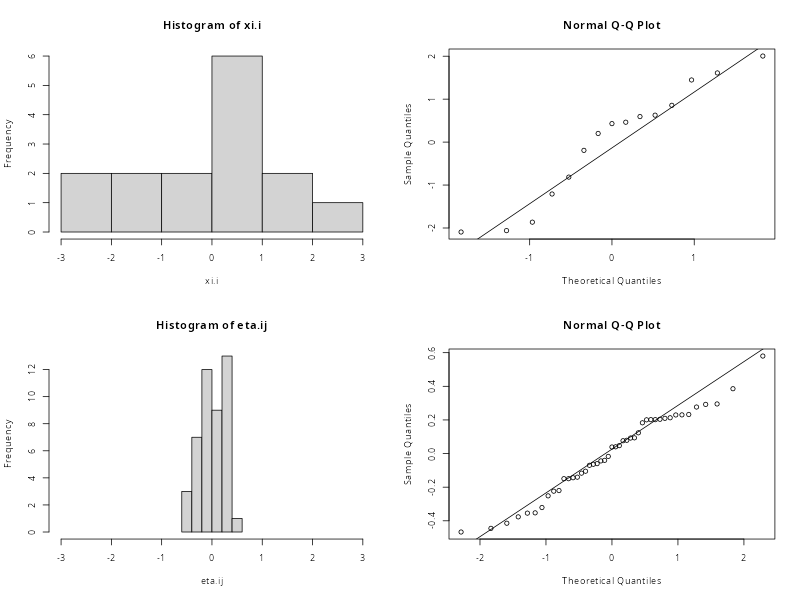

In [8]:
xi.i   <- random.effects(lme.mod)[,1]
eta.ij <- residuals(lme.mod)

par(mfrow=c(2,2))

# plot xi.i
hist(xi.i, xlim=c(-3,3))
qqnorm(xi.i)
qqline(xi.i)

# plot eta.ij
hist(eta.ij, xlim=c(-3,3))
qqnorm(eta.ij)
qqline(eta.ij)

Although the amount of data in this example makes the distributional form harder to verify, the key elements to notice here are that both distributions are centred on 0. So the expected values of both $\xi_{i}$ and $\eta_{ij}$ are 0. This is why the expected population effect is driven purely by the fixed-effects because, on average, the errors are 0. Secondly, the distribution of $\xi_{i}$ is *much wider* than the distribution of $\eta_{ij}$. This is because the distribution of $\xi_{i}$ reflects measurements from *different subjects* and the distribution of $\eta_{ij}$ reflects measurements from the *same subject*.

## Inference in Mixed-effects Models

### The Implied Marginal Model
... From this perspective, a mixed-effects model is simply GLS, but with a more sophisticated way of constructing the variance-covariance matrix using the random effects. This leads to some important consequences:

1. The inferential issues around GLS are *identical* for mixed-effects
2. The covariance structure is *more restricted* under mixed-effects, because it is constrained by the random effects themselves 

... The advantages of GLS are still there. For instance, the correct error term for each test can be automatically generated from the covariance structure. So while the model itself may be no better than the repeated measures ANOVA, it is infinitely *more practical* because we do not need to mess around manually assigning error terms to different tests (and worrying about getting this wrong).

## Inference Using `nlme`

In [10]:
summary(lme.mod)

Linear mixed-effects model fit by REML
  Data: anxiety.long 
       AIC      BIC    logLik
  94.43711 103.1255 -42.21856

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    1.344507 0.3034458

Fixed effects:  score ~ time 
                Value Std.Error DF   t-value p-value
(Intercept) 17.013333 0.3558818 28  47.80614       0
timet2      -2.000000 0.1108027 28 -18.05009       0
timet3      -3.453333 0.1108027 28 -31.16650       0
 Correlation: 
       (Intr) timet2
timet2 -0.156       
timet3 -0.156  0.500

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-1.5378504 -0.4924282  0.1284212  0.6647537  1.9114200 

Number of Observations: 45
Number of Groups: 15 

In [15]:
library(car)
Anova(lme.mod)

Analysis of Deviance Table (Type II tests)

Response: score
      Chisq Df Pr(>Chisq)    
time 979.46  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1